In [76]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from skimage import io, transform
from keras.utils import to_categorical
import time
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

In [77]:
#path to images
img_dir = "./train"

#list all available images type
print(os.listdir(img_dir))

['livingroom', 'store', 'bedroom', 'opencountry', 'industrial', 'CALsuburb', 'highway', 'forest', 'PARoffice', 'kitchen', 'insidecity', 'street', 'tallbuilding', 'mountain', 'coast']


In [124]:
def load_data(img_dir):
    X = []
    y = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
            if file_name.endswith('jpg'):
                im = io.imread(f'{img_dir}/{folder_name}/{file_name}','gray')
                if im is not None:
                    im = transform.resize(im, (100, 100,3))
                    X.append(im)
                    y.append(folder_name)
        idx+=1
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
    
    

In [125]:
X,y = load_data(img_dir)

  0%|          | 0/189 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 260/260 [00:00<00:00, 314.71it/s]


In [126]:
print(X.shape,y.shape)

(2985, 100, 100, 3) (2985,)


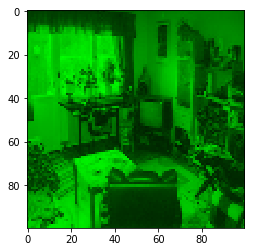

In [127]:
plt.grid(False)
plt.imshow(X[0])

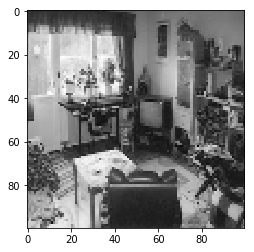

In [128]:
plt.grid(False)
plt.imshow(image,'gray')

In [109]:
# # image preprocessing
# image=X[0].astype('float32')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.grid(False)
# plt.imshow(image,'gray')

In [129]:
mapping={'CALsuburb':9,
'PARoffice':7,
'bedroom':12,
'coast':10,
'forest':4,
'highway':14,
'industrial':2,
'insidecity':3,
'kitchen':0,
'livingroom':5,
'mountain':8,
'opencountry':6,
'store':11,
'street':1,
'tallbuilding':13}

In [130]:
print(mapping)

{'CALsuburb': 9, 'PARoffice': 7, 'bedroom': 12, 'coast': 10, 'forest': 4, 'highway': 14, 'industrial': 2, 'insidecity': 3, 'kitchen': 0, 'livingroom': 5, 'mountain': 8, 'opencountry': 6, 'store': 11, 'street': 1, 'tallbuilding': 13}


In [131]:
for key,value in mapping.items():
    y[y==key]=value

In [132]:
#fix y
y = y.reshape(-1,1)

In [133]:
y.shape

(2985, 1)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [135]:
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test
train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((2388, 100, 100, 3), (2388, 1), (597, 100, 100, 3), (597, 1))

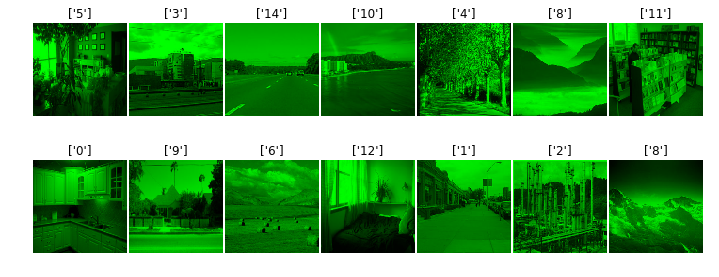

In [136]:
#show random samples
rand_14 = np.random.randint(0, train_img.shape[0],14)
sample_img = train_img[rand_14]
sample_labels = train_labels[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01})
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_img[image_index])
        ax[r,c].set_title('%s' % sample_labels[image_index])
plt.show()
plt.close()

In [137]:
#one-hot-encode the labels
num_classes = 15
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((2388, 15), (597, 15))

In [138]:
# re-shape the images data
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((2388, 100, 100, 3), (597, 100, 100, 3))

In [139]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels_cat.shape

((2150, 100, 100, 3),
 (2150, 15),
 (238, 100, 100, 3),
 (238, 15),
 (597, 100, 100, 3),
 (597, 15))

In [140]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [141]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [143]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import numpy as np
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import mnist
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import Image

In [144]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.25,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
# datagen = ImageDataGenerator(
#     rotation_range=8,
#     shear_range=0.3,
#     zoom_range = 0.08,
#     width_shift_range=0.08,
#     height_shift_range=0.08)

In [145]:
#create multiple cnn model for ensembling
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# use adam optimizer and categorical cross entropy cost
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [146]:
# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# train
epochs = 50
j=0
start_time = time.time()
history = model.fit_generator(datagen.flow(train_data2, train_labels_cat2, batch_size=64),epochs = epochs, steps_per_epoch = train_data2.shape[0]/64,validation_data = (val_data, val_labels_cat), callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,history.history['acc'][epochs-1],history.history['val_acc'][epochs-1]))

Epoch 1/50
34/33 [==============================] - 5s 151ms/step - loss: 3.7703 - acc: 0.1410 - val_loss: 9.9238 - val_acc: 0.1513
Epoch 2/50
34/33 [==============================] - 4s 115ms/step - loss: 3.2244 - acc: 0.2272 - val_loss: 9.2070 - val_acc: 0.2269
Epoch 3/50
34/33 [==============================] - 4s 123ms/step - loss: 2.8890 - acc: 0.2686 - val_loss: 6.3795 - val_acc: 0.2605
Epoch 4/50
34/33 [==============================] - 4s 119ms/step - loss: 2.7494 - acc: 0.3086 - val_loss: 7.4046 - val_acc: 0.1891
Epoch 5/50
34/33 [==============================] - 4s 113ms/step - loss: 2.5792 - acc: 0.3402 - val_loss: 7.2249 - val_acc: 0.1891
Epoch 6/50
34/33 [==============================] - 4s 119ms/step - loss: 2.3675 - acc: 0.3725 - val_loss: 8.6904 - val_acc: 0.1765
Epoch 7/50
34/33 [==============================] - 4s 122ms/step - loss: 2.2288 - acc: 0.3989 - val_loss: 13.4709 - val_acc: 0.0924
Epoch 8/50
34/33 [==============================] - 4s 116ms/step - loss: 2

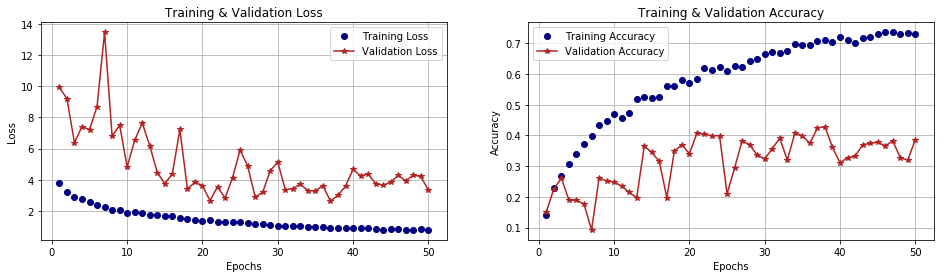

In [147]:
show_plots(history.history)

In [ ]:
#處理img_submission.csv

In [149]:
df=pd.read_csv('img-submission.csv')
df.head()

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,1
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,1
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...,1
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1...,1
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06d...,1


In [176]:
testimage=df.iloc[:,0]
testimage=testimage+'.jpg'
print(testimage[0])

c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4a56a8e8aa2beede330.jpg


In [177]:
X2 = []
for file_name in testimage:
    im = io.imread(f'./testset/{file_name}')
    if im is not None:
        im = transform.resize(im, (100, 100,3))
        X2.append(im)
            

X2 = np.asarray(X2)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


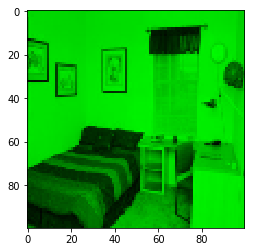

In [178]:
plt.grid(False)
plt.imshow(X2[0])

In [179]:
y2=[]
for i in range(len(X2)):
    img = X2[i]
    pred = model.predict_classes(img.reshape(-1,100,100,3))
    y2.append(pred)
    
y2 = np.asarray(y2)

In [180]:
X2.shape,y2.shape

((1500, 100, 100, 3), (1500, 1))

In [ ]:
# summit

df['class'] = y2
df.to_csv("img-submission2.csv", index= False)